In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import cv2
from albumentations import Rotate
from scipy import ndimage
import imutils
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import medial_axis, skeletonize, thin, remove_small_objects

In [2]:
# img_path = sorted(glob.glob('centered_imgs/*/*'))
img_path = sorted(glob.glob('FAZ-master/FAZ_Tortuosity/*')) #Original Folder

In [3]:
images = [plt.imread(i) for i in img_path]

In [21]:
class Image:
    def __init__(self,image):
        self.img_orig = image
        self.cleanImage = self.clean_image(self.img_orig)
        self.masked = self.getMasked(self.img_orig)
        self.contour = self.get_points(self.masked)
        self.unique = self.get_all_unique(self.contour)
        self.distance_tortousity = self.net_dist_tor(self.unique)
        
    def clean_image(self ,img):
        """
        To delete name and centercrop
        """
        H,W,_ = img.shape
        img = img[:W,...]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img[W//4:W//4+W//2,W//4:W//4+W//2]
        return img
    def getMasked(self ,img_orig):
        img_orig = self.clean_image(img_orig)
        kernel = np.ones((2,2),np.uint8) #kernel for erosion and dilation

        # img_denoise = cv2.fastNlMeansDenoising(img_orig,None,39,7,21) #mean denoising

        image = (hessian(img_orig,)*255).astype('uint8') #ridge detection

        # image =  cv2.dilate(image,kernel,iterations = 1) #to join disconnected before removing small noise

        image = remove_small_objects(image.astype(bool), min_size=64, connectivity=0).astype(float)

        image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected 
        image = cv2.erode(image,kernel,iterations = 1)  #to join disconnected
        image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected
        image = cv2.erode(image,kernel,iterations = 1)  #to join disconnected
        image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected

        #Use any one below
        skel = skeletonize(image)
        # skel = thin(image)
        # med, distance = medial_axis(image, return_distance=True)
        # # skel = med*distance

        #To get the circular part
        mask = np.zeros_like(image, np.uint8)
        H,W = image.shape
        mask = cv2.circle(mask, (H//2,W//2), H//2, (255,255,255),thickness=-1)
        masked_data = cv2.bitwise_and(skel*255, skel*255, mask=mask)
        return masked_data
    def get_points(self ,skeleton_image):
        cnts = cv2.findContours(skeleton_image.copy().astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        cnts = imutils.grab_contours(cnts)
        return cnts
    def num_to_str(self ,contour):
        str_list = list()
        for c in contour:
            str_list.append(str(c[0][0])+str(c[0][1]))
        return str_list
    def get_unique(self ,contour):
        cont = contour.copy()
        str_list = self.num_to_str(cont)
        index_dict = dict()
        for i in range(len(str_list)):
            if str_list[i] not in index_dict.keys():
                index_dict[str_list[i]] = i
        new_dict = dict((val,key) for key,val in index_dict.items())
        sub_cont = list()
        keys = list(new_dict.keys())
        keys.sort()
        sub_cont.append(list())
        last_ind = 0
        sub_cont[last_ind].append(new_dict[keys[0]])
        for i in range(len(keys)-1):
            if keys[i+1]-keys[i]!=1:
                last_ind+=1
                sub_cont.append(list())
                sub_cont[last_ind].append(new_dict[keys[i+1]])
            else:
                sub_cont[last_ind].append(new_dict[keys[i+1]])
        num_cont = sub_cont.copy()
        for l in range(len(num_cont)):
            for s in range(len(num_cont[l])):
                n = int(num_cont[l][s])
                x = n//1000
                y = n%1000
                num_cont[l][s] = [x,y]
        return num_cont
    def _distance_2p(self,x1, y1, x2, y2):
        return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


    def _curve_length(self,x, y):

        distance = 0
        for i in range(0, len(x) - 1):
            distance += self._distance_2p(x[i], y[i], x[i + 1], y[i + 1])
        return distance


    def _chord_length(self,x, y):

        return self._distance_2p(x[0], y[0], x[len(x) - 1], y[len(y) - 1])


    def _detect_inflection_points(self,x, y):

        cf = np.convolve(y, [1, -1])
        inflection_points = []
        for iterator in range(2, len(x)):
            if np.sign(cf[iterator]) != np.sign(cf[iterator - 1]):
                inflection_points.append(iterator - 1)
        return inflection_points


    def distance_measure_tortuosity(self,contour):

        x = list()
        y = list()
        for pixel in contour:
            x.append(pixel[1])
            y.append(pixel[0])
        if len(x) < 2:
            return 0

        return self._curve_length(x, y) /self. _chord_length(x, y)


    def distance_inflection_count_tortuosity(contour):

        x = list()
        y = list()
        for pixel in contour:
            x.append(pixel[1])
            y.append(pixel[0])

        return distance_measure_tortuosity(contour) * (len(_detect_inflection_points(x, y)) + 1)
    def get_all_unique(self ,contours):
        unique = list()
        for contour in contours:
            x = self.get_unique(contour)
            unique.append(x)
        return unique
    def net_dist_tor(self , unique):
        tor = 0
        for contour in unique:
            for curve in contour:
                tor+=self.distance_measure_tortuosity(curve)
        return tor

In [22]:
x = Image(images[0])

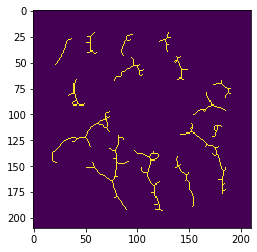

In [23]:
plt.imshow(x.masked)

In [24]:
im = [Image(i) for i in images]

In [25]:
dist = list()
for i in im:
    dist.append(i.distance_tortousity)

In [26]:
dist = [i.distance_tortousity for i in im]

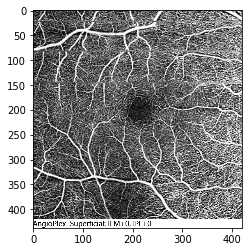

In [27]:
plt.imshow(im[0].img_orig)

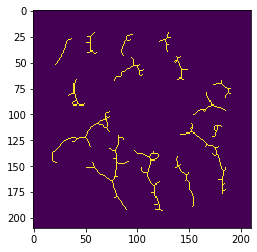

In [28]:
plt.imshow(im[0].masked)

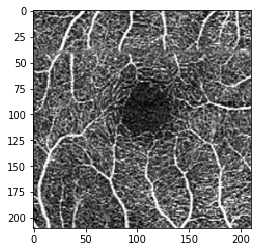

In [30]:
plt.imshow(im[0].cleanImage,cmap = 'gray')